In [1]:
from collections import Counter
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from nltk import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

import unidecode

In [2]:
df=pd.read_csv("partial_scraping.csv")

# Création Fonction Split Salary

In [3]:
def split_salary(row):
    salary = row["Salary"]
    if "-" in salary:
        split = salary.split("-")
        salary_min = split[0]
        salary_max = split[1]
    else:
        salary_min = salary
        salary_max = salary
    
    row["salary_min"] = salary_min.replace("€","")\
                                  .replace("par an","")\
                                  .replace("par mois","")\
                                  .replace("par semaine","")\
                                  .replace("par jour","")\
                                  .replace("par heure","")\
                                  .replace("\xa0","")
    row["salary_max"] = salary_max.replace("€","")\
                                  .replace("par an","")\
                                  .replace("par mois","")\
                                  .replace("par semaine","")\
                                  .replace("par jour","")\
                                  .replace("par heure","")\
                                  .replace("\xa0","")
    
    if "an" in row["Salary"]:
        row["salary_period"] = "year"

    if "mois" in row["Salary"]:
        if float(row["salary_min"]) < 1500:
            row["salary_min"] = float(row["salary_min"])
            row["salary_max"] = float(row["salary_max"])
            row["salary_period"] = "month"
        else:
            row["salary_min"] = float(row["salary_min"])*12
            row["salary_max"] = float(row["salary_max"])*12
            row["salary_period"] = "year"
    
    if "semaine" in row["Salary"]:
        row["salary_min"] = float(row["salary_min"])
        row["salary_max"] = float(row["salary_max"])
        row["salary_period"] = "week"

    if "jour" in row["Salary"]:
        row["salary_min"] = float(row["salary_min"])
        row["salary_max"] = float(row["salary_max"])
        row["salary_period"] = "day"

    if "heure" in row["Salary"]:
        row["salary_min"] = float(row["salary_min"].replace(",","."))
        row["salary_max"] = float(row["salary_max"].replace(",","."))
        row["salary_period"] = "hour"
        
    return row

# Création des colonnes salary max et salary min

In [4]:
stop_words = stopwords.words('french')

In [5]:
def preprocessing_text(text, stopwords):
    text = text.lower()
    text = re.sub(r'[^\w|\s|+]', ' ', text)
    text = re.sub(r'[_|\|]', ' ', text)
    text = unidecode.unidecode(text)
    text = re.sub(r'\b[abd-qs-z]\b', ' ', text)
    text = re.sub(r'\d{2,}', ' ', text)

    # STOPWORDS
    tokenized_words = word_tokenize(text)
    tokenized_words = [word for word in tokenized_words if word not in stopwords]

    return tokenized_words

In [6]:
df_salary = df[~df.Salary.isna()]

df_salary = df_salary.apply(lambda column: column.apply(preprocessing_text, args=(stop_words,))
                                          if column.name in ['Title', 'Description']
                                          else column)

In [7]:
df_salary = df_salary.apply(split_salary, axis=1)
df_salary["salary_min"]=pd.to_numeric(df_salary["salary_min"],'coerce')
df_salary["salary_max"]=pd.to_numeric(df_salary["salary_max"],'coerce')

In [8]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 1 to 1581
Data columns (total 12 columns):
_id                  267 non-null object
Title                267 non-null object
Company              267 non-null object
Location             267 non-null object
Salary               267 non-null object
Description          267 non-null object
Date                 184 non-null object
Job_Search           267 non-null object
Department_Search    267 non-null object
salary_min           267 non-null float64
salary_max           267 non-null float64
salary_period        267 non-null object
dtypes: float64(2), object(10)
memory usage: 27.1+ KB


## Création colonne salary mean

In [9]:
df_salary["salary_mean"] = (df_salary["salary_min"]+df_salary["salary_max"])/2

In [10]:
df_salary

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,salary_min,salary_max,salary_period,salary_mean
1,p_af45e2a447bae65b,"[big, data, engineer]",Square Sense,Paris (75),50 000 € - 60 000 € par an,"[technology, domains, kafka, spark, python, ja...",07/10/2019,Data,75,50000.0,60000.0,year,55000.0
3,p_9ba1a3ab379e9b6e,"[data, engineer, freelance]",Human Job,Paris (75),500 € par mois,"[soutenir, developpement, plateforme, big, dat...",07/10/2019,Data,75,500.0,500.0,month,500.0
4,p_8ccc668de734a40e,"[data, engineer, freelance]",HR-TEAM,Paris (75),500 € - 650 € par mois,"[contexte, recherchons, aujourd, hui, plusieur...",07/10/2019,Data,75,500.0,650.0,month,575.0
24,p_4ed079af45cf052d,"[advertising, data, analyst]",Work4 Labs,Paris 9e (75),1 000 € par semaine,"[intrigue, potentiel, facebook, recrutement, v...",07/10/2019,Data,75,1000.0,1000.0,week,1000.0
26,p_8d5f755b3a18ea80,"[data, scientist]",HPR,Paris (75),45 000 € - 55 000 € par an,"[contexte, recherchons, client, entreprise, in...",05/10/2019,Data,75,45000.0,55000.0,year,50000.0
29,p_f74c94c78f09bd8e,"[senior, data, scientist]",Pivot & Co,Paris 8e (75),60 000 € par an,"[areas, data, science, media, effectiveness, r...",05/10/2019,Data,75,60000.0,60000.0,year,60000.0
38,p_31d61797124bb736,"[data, analyst, stage]",Pretto,Paris (75),800 € - 1 200 € par mois,"[startup, croit, structure, toute, vitesse, ro...",05/10/2019,Data,75,800.0,1200.0,month,1000.0
51,pj_ab98b936909d935e,"[controleur, gestion, data, analyst, junior]",SH CONSEILS,Paris 8e (75),33 000 € - 38 000 € par an,"[operateur, telecoms, premier, plan, france, f...",NaN,Data,75,33000.0,38000.0,year,35500.0
69,pj_8e999445ab7fad30,"[developpeur, web, data, django, python, start...",VisitData,Paris (75),44 000 € - 48 000 € par an,"[propos, visitdata, developpons, commercialiso...",NaN,Data,75,44000.0,48000.0,year,46000.0
70,pj_a392103fc5e8514d,"[data, engineer]",Neoxia,Paris (75),45 000 € - 55 000 € par an,"[mission, sein, team, data, neoxia, travailler...",NaN,Data,75,45000.0,55000.0,year,50000.0


# Je ne prends que les salaires qui sont 'par an' 

In [11]:
df_salary = df_salary[df_salary.salary_period == 'year']

## Quantiles salary min

In [12]:
df_salary.salary_min.describe()

count      227.000000
mean     42027.700441
std      10109.960558
min      20000.000000
25%      35000.000000
50%      40000.000000
75%      50000.000000
max      75000.000000
Name: salary_min, dtype: float64

## Quantiles salary max

In [13]:
df_salary.salary_max.describe()

count       227.000000
mean      50117.480176
std       12447.037531
min       20388.000000
25%       43500.000000
50%       50000.000000
75%       55000.000000
max      110000.000000
Name: salary_max, dtype: float64

## Quantiles salary mean

In [14]:
df_salary.salary_mean.describe()

count      227.000000
mean     46072.590308
std      10564.855435
min      20388.000000
25%      40000.000000
50%      45000.000000
75%      52500.000000
max      90000.000000
Name: salary_mean, dtype: float64

In [15]:
tercile_1 = np.quantile(df_salary.salary_mean, 1/3)
tercile_1

41500.0

In [16]:
tercile_2 = np.quantile(df_salary.salary_mean, 2/3)
tercile_2

50000.0

# Création colonne class label par rapport aux quantiles salary mean

In [17]:
def classification(x):
    if x <= tercile_1:
        label = 1
    elif x <= tercile_2:
        label = 2
    else:
        label = 3
    return label

df_salary["salary_label"] = df_salary["salary_mean"].apply(classification)

C:\Users\Gryshka\Miniconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [18]:
df_salary.head(10)

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,salary_min,salary_max,salary_period,salary_mean,salary_label
1,p_af45e2a447bae65b,"[big, data, engineer]",Square Sense,Paris (75),50 000 € - 60 000 € par an,"[technology, domains, kafka, spark, python, ja...",07/10/2019,Data,75,50000.0,60000.0,year,55000.0,3
26,p_8d5f755b3a18ea80,"[data, scientist]",HPR,Paris (75),45 000 € - 55 000 € par an,"[contexte, recherchons, client, entreprise, in...",05/10/2019,Data,75,45000.0,55000.0,year,50000.0,2
29,p_f74c94c78f09bd8e,"[senior, data, scientist]",Pivot & Co,Paris 8e (75),60 000 € par an,"[areas, data, science, media, effectiveness, r...",05/10/2019,Data,75,60000.0,60000.0,year,60000.0,3
51,pj_ab98b936909d935e,"[controleur, gestion, data, analyst, junior]",SH CONSEILS,Paris 8e (75),33 000 € - 38 000 € par an,"[operateur, telecoms, premier, plan, france, f...",NaN,Data,75,33000.0,38000.0,year,35500.0,1
69,pj_8e999445ab7fad30,"[developpeur, web, data, django, python, start...",VisitData,Paris (75),44 000 € - 48 000 € par an,"[propos, visitdata, developpons, commercialiso...",NaN,Data,75,44000.0,48000.0,year,46000.0,2
70,pj_a392103fc5e8514d,"[data, engineer]",Neoxia,Paris (75),45 000 € - 55 000 € par an,"[mission, sein, team, data, neoxia, travailler...",NaN,Data,75,45000.0,55000.0,year,50000.0,2
88,pj_55779e456b8acd1f,"[data, engineer]",PRESTASHOP SA,Paris 9e (75),50 000 € par an,"[sql, nodejs, python, google, cloud, dataflow,...",NaN,Data,75,50000.0,50000.0,year,50000.0,2
89,pj_fecbe7703c9699cd,"[digital, data, analyst]",Aravati,Paris (75),55 000 € par an,"[r, python, adobe, analytics, at, internet, go...",NaN,Data,75,55000.0,55000.0,year,55000.0,3
91,pj_df4101ae5cc11c6f,"[cdi, developpeur, fullstack, data, engineer]",La Relève,Paris (75),34 000 € - 40 000 € par an,"[cree, entreprise, premier, distributeur, cons...",NaN,Data,75,34000.0,40000.0,year,37000.0,1
98,p_90b7995634268e85,"[projeteur, data, center]",PROJETS,Paris (75),2 500 € - 3 200 € par mois,"[projet, agence, specialisee, delegation, pers...",04/10/2019,Data,75,30000.0,38400.0,year,34200.0,1


# Création des df par tranches label

In [19]:
label_1 = df_salary[df_salary["salary_label"]==1]
label_2 = df_salary[df_salary["salary_label"]==2]
label_3 = df_salary[df_salary["salary_label"]==3]

In [20]:
df_salary.Job_Search.value_counts(normalize=True) * 100

Développeur    55.947137
Data           44.052863
Name: Job_Search, dtype: float64

In [21]:
label_1.Department_Search.value_counts(normalize=True) * 100

75                  48.717949
Loire-Atlantique    19.230769
Rhône               14.102564
Gironde             12.820513
Haute-Garonne        5.128205
Name: Department_Search, dtype: float64

In [22]:
label_1.Job_Search.value_counts(normalize=True) * 100

Développeur    69.230769
Data           30.769231
Name: Job_Search, dtype: float64

In [23]:
label_2.Department_Search.value_counts(normalize=True) * 100

75                  81.818182
Rhône                7.954545
Loire-Atlantique     5.681818
Gironde              4.545455
Name: Department_Search, dtype: float64

In [24]:
label_2.Job_Search.value_counts(normalize=True) * 100

Développeur    59.090909
Data           40.909091
Name: Job_Search, dtype: float64

In [25]:
label_3.Department_Search.value_counts(normalize=True) * 100

75                  81.967213
Gironde             13.114754
Rhône                3.278689
Loire-Atlantique     1.639344
Name: Department_Search, dtype: float64

In [26]:
label_3.Job_Search.value_counts(normalize=True) * 100

Data           65.57377
Développeur    34.42623
Name: Job_Search, dtype: float64

## StopWords

In [27]:
stop_words = stopwords.words('french')

tag_title_1 = label_1["Title"]
tag_title_2 = label_2["Title"]
tag_title_3 = label_3["Title"]

In [28]:
# créer un dictionnaire avec la frequence de chaque mot de tag_title1
# on va ordonner par la valeur du dictionnaire en ordre descendant

result_1 = tag_title_1.apply(Counter).sum().items()
result_1 = sorted(result_1, key=lambda kv : kv[1], reverse=True)

result_2 = tag_title_2.apply(Counter).sum().items()
result_2 = sorted(result_2, key=lambda kv : kv[1], reverse=True)

result_3 = tag_title_3.apply(Counter).sum().items()
result_3 = sorted(result_3, key=lambda kv : kv[1], reverse=True)

### Je crée le dictionnaire qui associe la frequece de chaque mot sur chaque df

In [29]:
result_series_1 = dict(result_1)
result_series_2 = dict(result_2)
result_series_3 = dict(result_3)

In [30]:
result_series_1

{'developpeur': 54,
 'data': 26,
 'informatique': 11,
 'junior': 8,
 'java': 8,
 'web': 7,
 'scientist': 6,
 'ingenieur': 6,
 'fullstack': 5,
 'net': 5,
 'end': 5,
 'php': 5,
 'cdi': 4,
 'python': 4,
 'full': 4,
 'stack': 4,
 'center': 3,
 'big': 3,
 'consultant': 3,
 'back': 3,
 'front': 3,
 'paris': 3,
 'angular': 3,
 'developpeurs': 3,
 'controleur': 2,
 'gestion': 2,
 'analyst': 2,
 'engineer': 2,
 'projeteur': 2,
 'technicien': 2,
 'tech': 2,
 'manager': 2,
 'sql': 2,
 'biofortis': 2,
 'herblain': 2,
 'js': 2,
 'logiciel': 2,
 'symfony': 2,
 'android': 2,
 'analyste': 2,
 'concepteur': 2,
 'mobile': 2,
 'confirme': 2,
 'produit': 2,
 'centre': 2,
 'ville': 2,
 'devops': 1,
 'lead': 1,
 'visualisation': 1,
 'controller': 1,
 'docteur': 1,
 'sciences': 1,
 'sequencage': 1,
 'assistant': 1,
 'saint': 1,
 'technique': 1,
 'oracle': 1,
 'pl': 1,
 'obiee': 1,
 'reseau': 1,
 'hotline': 1,
 'telephonie': 1,
 'high': 1,
 'applications': 1,
 'j2ee': 1,
 'sharepoint': 1,
 'environnement': 1,

# Visualisation du wordcloud title de chaque df

In [31]:
wordcloud_1 = WordCloud(max_words=50).generate_from_frequencies(result_series_1)
wordcloud_2 = WordCloud(max_words=50).generate_from_frequencies(result_series_2)
wordcloud_3 = WordCloud(max_words=50).generate_from_frequencies(result_series_3)

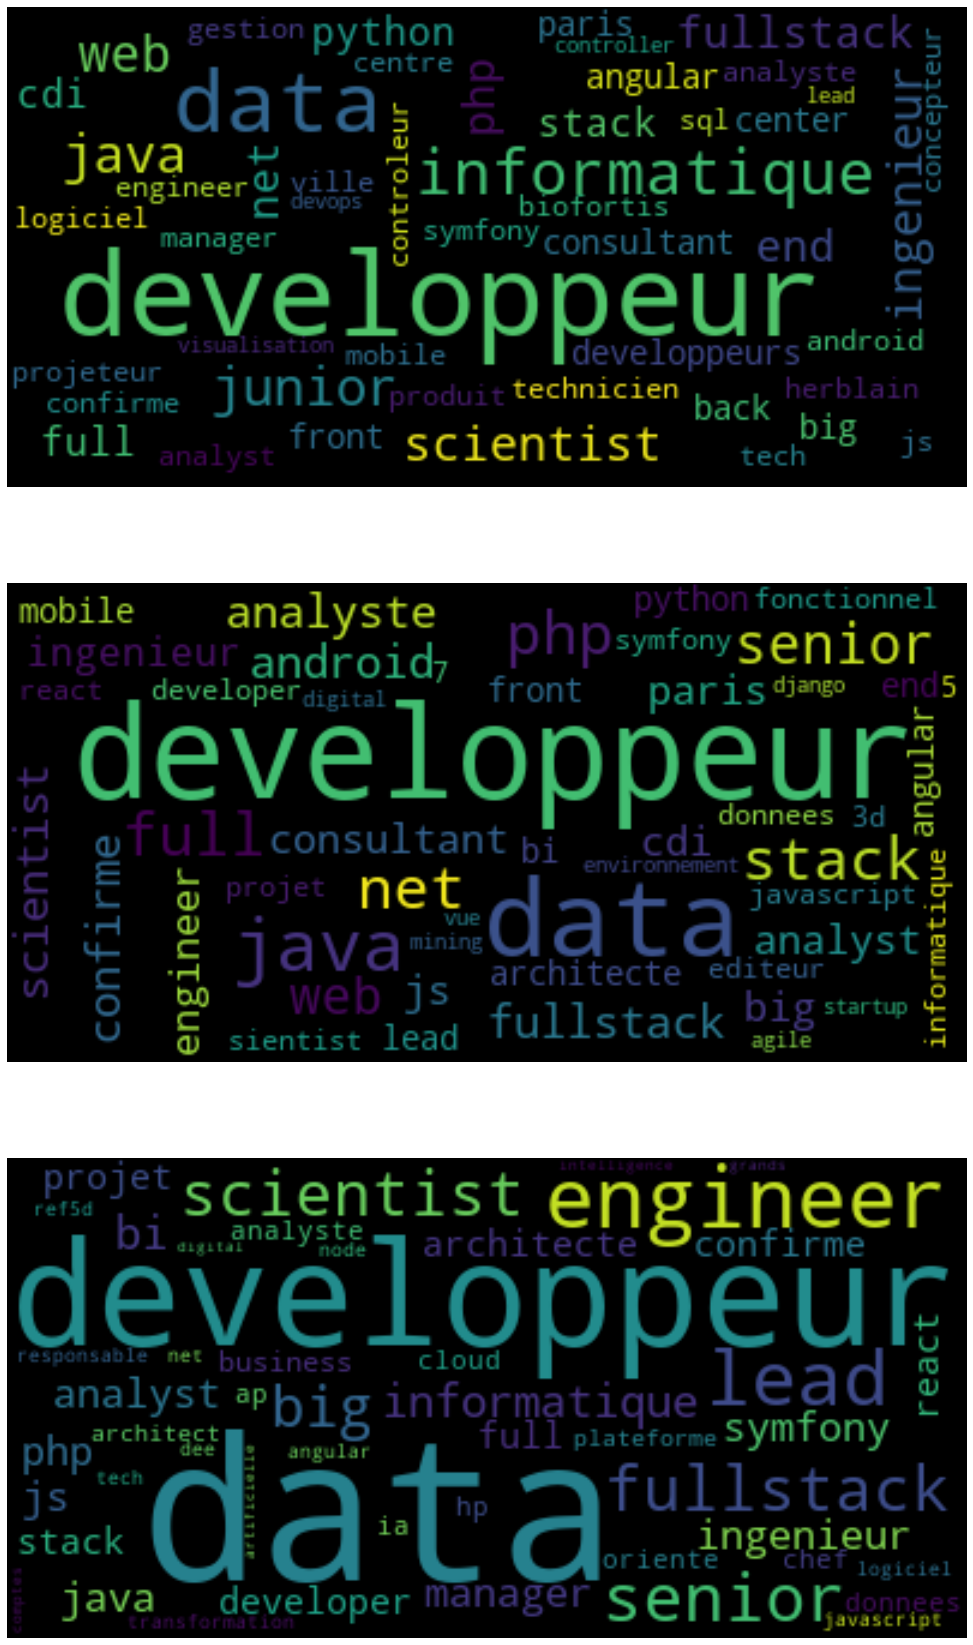

In [32]:
plt.figure(figsize = (25, 30))

plt.subplot(3, 1, 1)
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")

plt.subplot(3, 1, 2)
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.imshow(wordcloud_3, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
tag_desc_1 = label_1["Description"]
tag_desc_2 = label_2["Description"]
tag_desc_3 = label_3["Description"]

In [34]:
tag_desc_3

1       [technology, domains, kafka, spark, python, ja...
29      [areas, data, science, media, effectiveness, r...
89      [r, python, adobe, analytics, at, internet, go...
105     [propos, monde, demain, entre, mains, rejoigne...
109     [sql, python, r, pilotage, projets, audit, arc...
                              ...                        
1340    [descriptif, societe, cette, strat, up, ete, c...
1430    [operateur, energie, present, plus, pays, enga...
1438    [expectra, leader, france, interim, specialise...
1447    [contexte, etes, recherche, entreprise, ambian...
1538    [poste, missions, cadre, fort, developpement, ...
Name: Description, Length: 61, dtype: object

# création des dictionnaires qui à chaque mot associe sa frequence

In [35]:
desc_1 = tag_desc_1.apply(Counter).sum().items()
desc_1 = sorted(desc_1, key=lambda kv : kv[1], reverse=True) 
dict_desc_1 = {k: v for k,v in desc_1}

desc_2 = tag_desc_2.apply(Counter).sum().items()
desc_2 = sorted(desc_2, key=lambda kv : kv[1], reverse=True) 
dict_desc_2 = {k: v for k,v in desc_2}

desc_3 = tag_desc_3.apply(Counter).sum().items()
desc_3 = sorted(desc_3, key=lambda kv : kv[1], reverse=True) 
dict_desc_3 = {k: v for k,v in desc_3}

# Visualisation du wordcloud job_desc pour chaque df

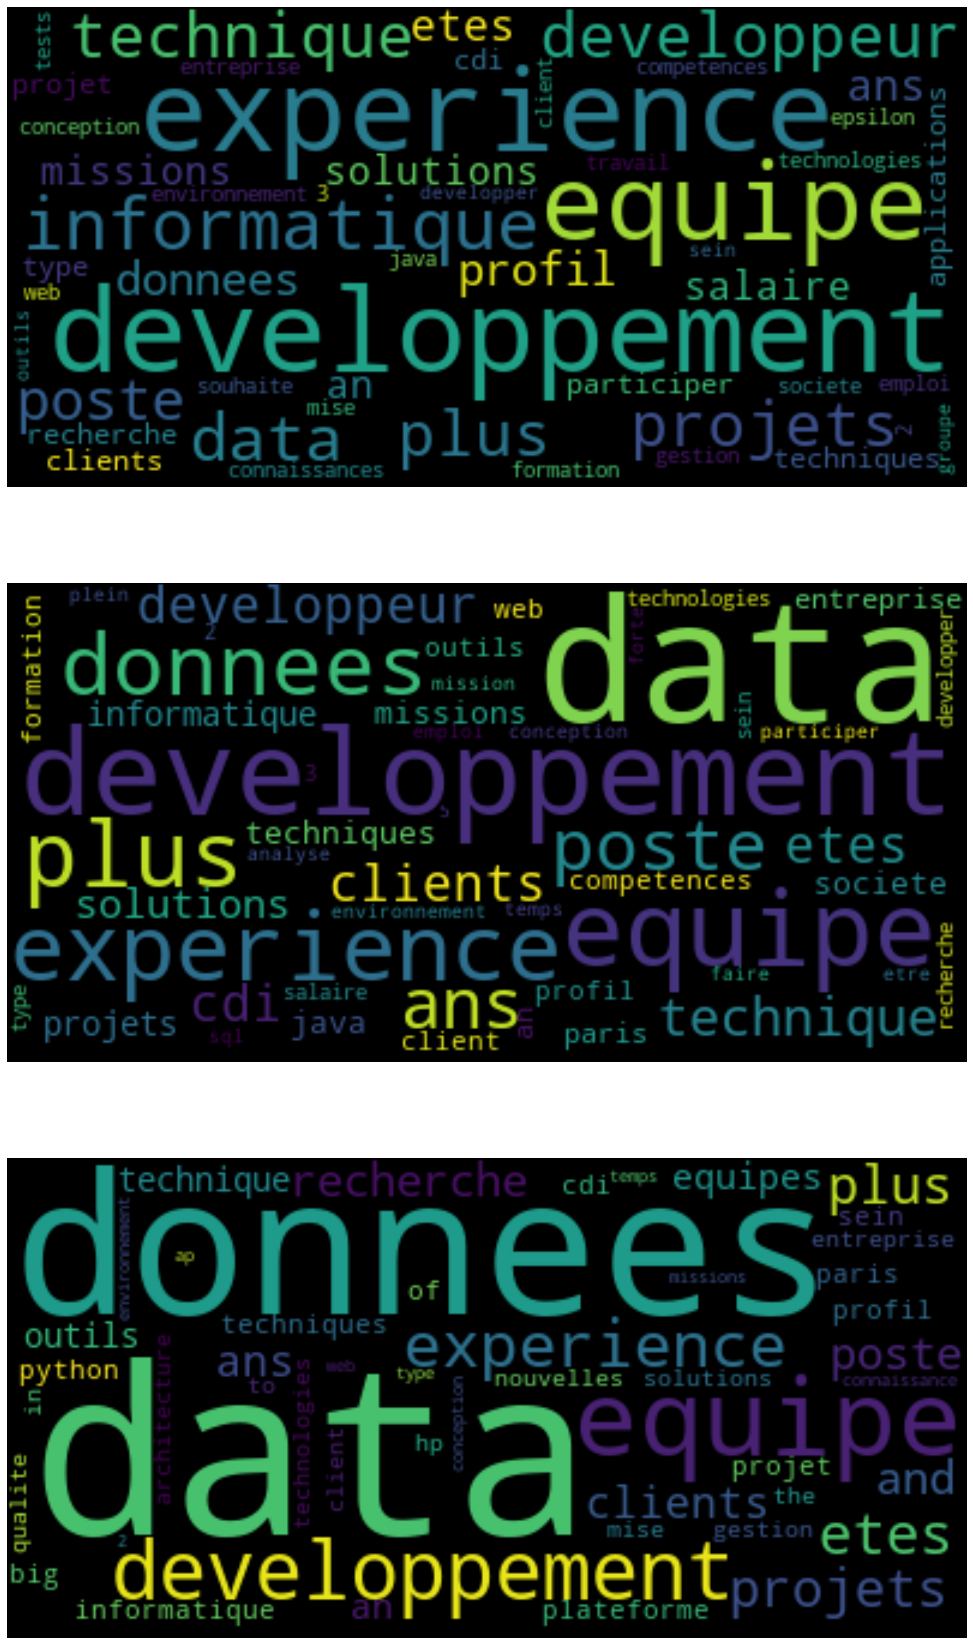

In [36]:
wordcloud6 = WordCloud(max_words=50).generate_from_frequencies(dict_desc_1)
wordcloud7 = WordCloud(max_words=50).generate_from_frequencies(dict_desc_2)
wordcloud8 = WordCloud(max_words=50).generate_from_frequencies(dict_desc_3)

figure = plt.figure(figsize = (25, 30))
plt.figure(1)
plt.subplot(3, 1, 1)
plt.imshow(wordcloud6, interpolation="bilinear")
plt.axis("off")

plt.subplot(3, 1, 2)
plt.imshow(wordcloud7, interpolation="bilinear")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.imshow(wordcloud8, interpolation="bilinear")
plt.axis("off")

plt.show()

## prediction salaire avec job desc brut seulement

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
X_desc = df_salary.Description.apply(" ".join)
y = df_salary.salary_label

In [39]:
X_desc

1       technology domains kafka spark python java sca...
26      contexte recherchons client entreprise innovan...
29      areas data science media effectiveness roi mar...
51      operateur telecoms premier plan france fai tel...
69      propos visitdata developpons commercialisons s...
                              ...                        
1570    informatique nantes jobalert merieux biofortis...
1573    delia technologies ladevopsfamily delia techno...
1574    editeur logiciels developpons interne erp modu...
1575    delia technologies ladevopsfamily delia techno...
1579    rejoins bureau etude specialise automatisation...
Name: Description, Length: 227, dtype: object

In [40]:
vectorizer = TfidfVectorizer(ngram_range=(1, 4))
vectorizer.fit(X_desc)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [41]:
len(vectorizer.get_feature_names())

99582

In [42]:
X_desc_trans = pd.DataFrame(vectorizer.transform(X_desc).todense(), columns=vectorizer.get_feature_names())
X_desc_trans

,1er,1er progiciel,1er progiciel open,1er progiciel open source,1er progiciel opensource,1er progiciel opensource dedie,1ere,1ere marketplace,1ere marketplace europeenne,1ere marketplace europeenne bientot,...,zookeper ambari,zookeper ambari base,zookeper ambari base donnees,zwave,zwave competences,zwave competences requises,zwave competences requises expert,zwave wi,zwave wi fi,zwave wi fi ethernet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
import numpy as np
np.asmatrix(X_desc_trans)

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
word_counts = X_desc_trans.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

data             5.740231
developpement    3.816654
donnees          3.699549
equipe           3.196136
experience       2.898304
etes             2.642884
plus             2.542059
technique        2.451629
ans              2.442591
clients          2.417410
informatique     2.414518
poste            2.392331
projets          2.384955
developpeur      2.349412
java             2.309894
solutions        2.217492
techniques       2.202693
entreprise       2.064911
an               2.061954
recherche        2.056202
dtype: float64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_desc_trans), y, stratify=y)

In [46]:
rfc = RandomForestClassifier(n_estimators=5, random_state=42)
rfc.fit(X_train, y_train)

rfc.score(X_test,y_test)

0.49122807017543857

In [47]:
rfc.score(X_train, y_train)

0.9117647058823529

In [48]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_desc_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(30)

,feature,importance
37017,etre,0.016489
72097,principale,0.013399
81453,rigueur,0.011178
41877,formation,0.011136
25514,description offre,0.011022
14563,charge,0.010458
1791,agile,0.010389
77037,real,0.010376
59839,montee,0.010262
13728,cdi environ ans,0.009958


# Prédiction salaire avec Title seulement

In [49]:
X_title = df_salary.Title.apply(" ".join)
y = df_salary.salary_label

In [50]:
vectorizer_2 = TfidfVectorizer(ngram_range=(1, 4))
vectorizer_2.fit(X_title)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [51]:
len(vectorizer_2.get_feature_names())

1190

In [52]:
X_title_trans = pd.DataFrame(vectorizer_2.transform(X_title).todense(), columns=vectorizer_2.get_feature_names())
X_title_trans

,3d,3d rm,3d rm ra,3d rm ra hololens,3d unity,3d unity 3d,3d unity 3d rm,affaires,affaires expert,affaires expert data,...,web data django,web data django python,web developpeur,web front,web front end,web fullstack,web fullstack senior,web mobile,web mobile android,web mobile android ios
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.234489,0.234489,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [53]:
word_counts2 = X_title_trans.sum(axis=0)
word_counts2.sort_values(ascending = False).head(20)

developpeur                 20.113082
data                        17.387986
java                         8.213703
data engineer                7.706081
engineer                     7.706081
developpeur java             7.539486
data scientist               7.511999
scientist                    7.511999
informatique                 5.521444
php                          5.398989
net                          4.717186
developpeur php              4.649088
developpeur informatique     4.544175
ingenieur                    4.458785
senior                       4.158752
fullstack                    4.075958
full stack                   4.064097
full                         4.064097
stack                        4.064097
web                          3.733397
dtype: float64

In [54]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(np.asmatrix(X_title_trans), y, random_state=42, stratify=y)

In [55]:
rfc = RandomForestClassifier(7, random_state=42)
rfc.fit(X_train2, y_train2)

rfc.score(X_test2,y_test2)

0.45614035087719296

In [56]:
rfc.score(X_train2,y_train2)

0.9176470588235294

In [57]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_title_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(20)

,feature,importance
325,developpeur,0.058969
219,data,0.045240
390,developpeur informatique,0.031378
687,informatique,0.016757
19,analyst,0.015053
1171,web,0.014614
242,data controller,0.012984
188,confirme,0.011068
282,data scientist,0.010988
711,ingenieur,0.010679
